In [77]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [16]:
#loading data

train_path = 'train-metadata.csv'
test_path = 'test-metadata.csv'

train_metadata = pd.read_csv(train_path)
test_metadata = pd.read_csv(test_path)

train_metadata

C:\Users\IamRe\AppData\Local\Temp\ipykernel_24884\1857108021.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_path)


,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401054,ISIC_9999937,0,IP_1140263,70.0,male,anterior torso,6.80,TBP tile: close-up,3D: XP,22.574335,...,IL_9520694,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999988
401055,ISIC_9999951,0,IP_5678181,60.0,male,posterior torso,3.11,TBP tile: close-up,3D: white,19.977640,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999820
401056,ISIC_9999960,0,IP_0076153,65.0,female,anterior torso,2.05,TBP tile: close-up,3D: XP,17.332567,...,IL_9852274,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.999416
401057,ISIC_9999964,0,IP_5231513,30.0,female,anterior torso,2.80,TBP tile: close-up,3D: XP,22.288570,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,100.000000


In [17]:
#data preperation part, checking for null values

missing_val = train_metadata.isnull().sum()
print("Missing Values:\n", missing_val)

Missing Values:
 isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                        0
tbp_lv_d

In [18]:
# list of columns we want to remove
columns_to_remove = ['lesion_id', 'iddx_2', 'iddx_3', 'iddx_4', 'iddx_5', 'mel_mitotic_index', 'mel_thick_mm']

#specify these columns
train_metadata_cleaned = train_metadata.drop(columns=columns_to_remove, errors='ignore')

# remove rows with 0 values
train_metadata_cleaned_no_nulls = train_metadata_cleaned.dropna()

In [19]:
# showing the unique values in target = understand the distribution of data in that column
train_metadata_cleaned_no_nulls['target'].value_counts()

target
0    381533
1       381
Name: count, dtype: int64

In [31]:
# the data is imbalanced

# separate the classes based on 'target' column
class_0 = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 0]
class_1 = train_metadata_cleaned_no_nulls[train_metadata_cleaned_no_nulls['target'] == 1]

# downsample class 0 to class 1
class_0_downsampled = resample(class_0,
                               replace=False,  # sample without replacement
                               n_samples=len(class_1),  # match classes size
                               random_state=42) 

# combine the downsampled majority class with the minority class
balanced_data = pd.concat([class_0_downsampled, class_1])


print("Shape of balanced data:", balanced_data.shape)
print("Distribution after balancing:\n", balanced_data['target'].value_counts())


Shape of balanced data: (762, 48)
Distribution after balancing:
 target
0    381
1    381
Name: count, dtype: int64


In [32]:
train_metadata_balanced=balanced_data
train_metadata_balanced

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
44730,ISIC_1176500,0,IP_4013104,50.0,female,posterior torso,3.35,TBP tile: close-up,3D: white,21.195278,...,0.726667,60,-103.079308,1195.573975,227.486694,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.990058
362429,ISIC_9047349,0,IP_9057861,80.0,male,lower extremity,2.82,TBP tile: close-up,3D: white,17.323980,...,0.460432,110,-170.181000,764.250000,29.220830,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999270
17389,ISIC_0500366,0,IP_6894380,45.0,female,posterior torso,4.81,TBP tile: close-up,3D: white,19.021500,...,0.207865,15,66.219480,1457.846000,78.279170,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999990
367815,ISIC_9176171,0,IP_6422845,70.0,male,posterior torso,4.19,TBP tile: close-up,3D: white,19.501620,...,0.334615,55,-39.389570,1057.866000,169.172800,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.997030
192982,ISIC_4857877,0,IP_7331742,65.0,male,lower extremity,2.52,TBP tile: close-up,3D: XP,21.714430,...,0.185185,55,-150.631100,749.153000,-3.548462,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,Benign,Benign,99.999950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396165,ISIC_9877311,1,IP_4717387,50.0,female,posterior torso,8.16,TBP tile: close-up,3D: XP,17.351658,...,0.256480,165,-140.668518,1112.529053,96.400574,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,Malignant::Malignant adnexal epithelial prolif...,Malignant,99.197656
398671,ISIC_9941636,1,IP_7607582,60.0,female,posterior torso,5.65,TBP tile: close-up,3D: XP,21.990980,...,0.292531,140,63.765810,1252.122000,72.269710,Memorial Sloan Kettering Cancer Center,CC-BY,Malignant::Malignant adnexal epithelial prolif...,Malignant,99.985530
399936,ISIC_9972649,1,IP_9181133,60.0,male,lower extremity,8.51,TBP tile: close-up,3D: white,19.003400,...,0.461798,175,-72.287600,622.391700,82.021270,Memorial Sloan Kettering Cancer Center,CC-BY,Malignant::Malignant epidermal proliferations:...,Malignant,86.048290
399943,ISIC_9972877,1,IP_8877928,65.0,female,lower extremity,12.08,TBP tile: close-up,3D: white,23.465230,...,0.163862,20,-102.059400,518.162400,48.836550,Memorial Sloan Kettering Cancer Center,CC-BY,Malignant::Malignant melanocytic proliferation...,Malignant,99.786690


# visualizing

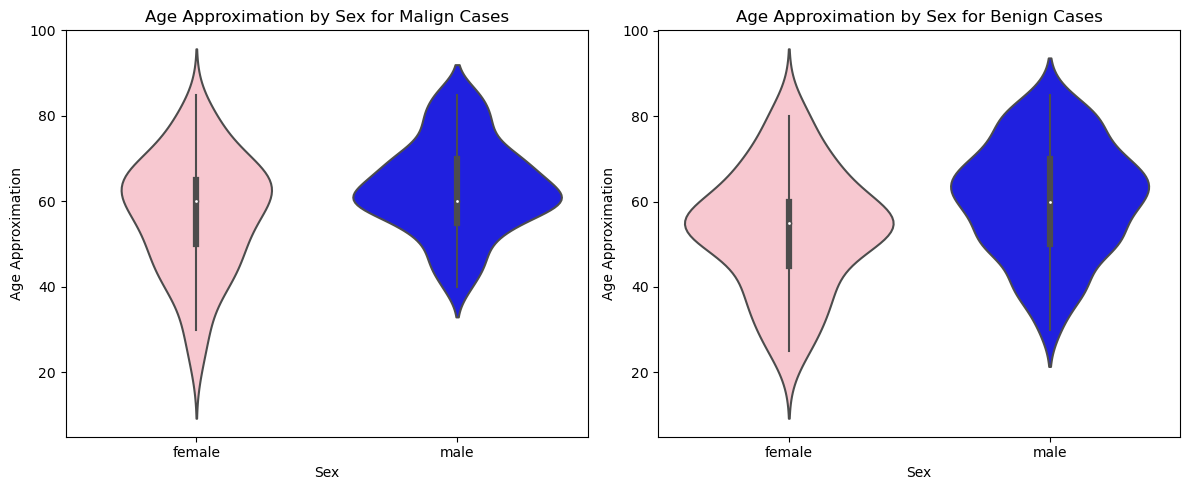

In [33]:
# filter the data to focus on a specific subset of the data
filtered_data_target_1 = train_metadata_balanced[train_metadata_balanced['target'] == 1]
filtered_data_target_0 = train_metadata_balanced[train_metadata_balanced['target'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# plot for target 1 (malign cases)
sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_1, palette=['pink', 'blue'], ax=axes[0])
axes[0].set_title('Age Approximation by Sex for Malign Cases')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Age Approximation')

# plot for target 0 (benign cases)
sns.violinplot(x='sex', y='age_approx', data=filtered_data_target_0, palette=['pink', 'blue'], ax=axes[1])
axes[1].set_title('Age Approximation by Sex for Benign Cases')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Age Approximation')

plt.tight_layout()
plt.show()


### We can see from the violin plot that women are more likely than males to develop skin cancer.

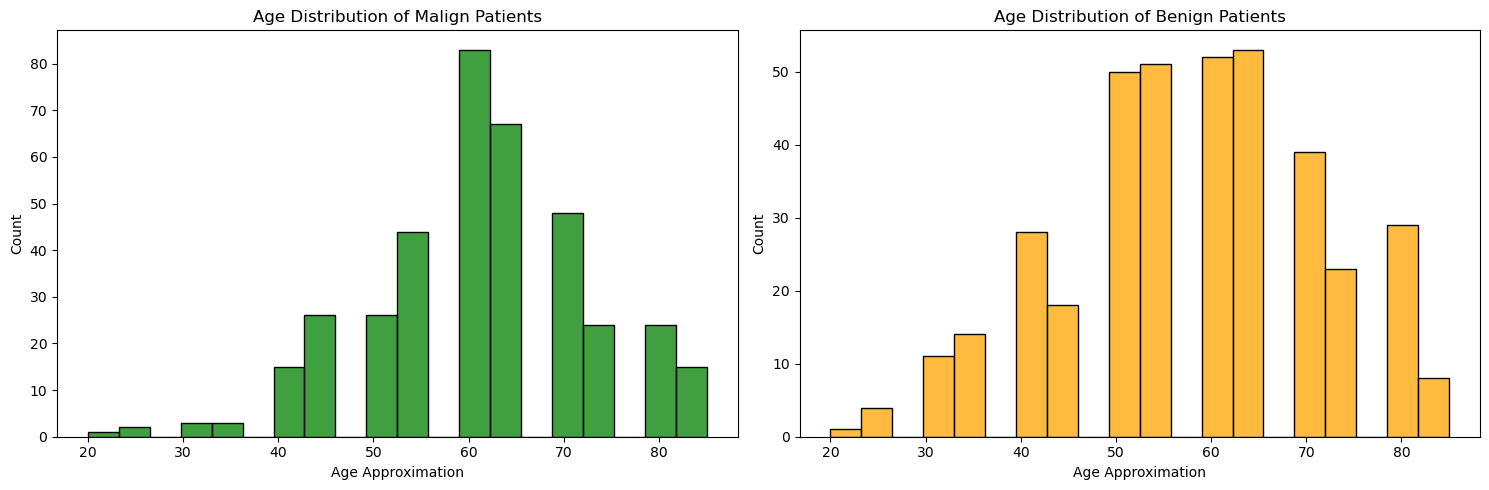

In [34]:
fig, axes1 = plt.subplots(1, 2, figsize=(15, 5))

# malign cases (target=1)
sns.histplot(filtered_data_target_1['age_approx'].dropna(), bins=20, color='green', ax=axes1[0])
axes1[0].set_title('Age Distribution of Malign Patients')
axes1[0].set_xlabel('Age Approximation')
axes1[0].set_ylabel('Count')

# benign cases (target=0)
sns.histplot(filtered_data_target_0['age_approx'].dropna(), bins=20, color='orange', ax=axes1[1])
axes1[1].set_title('Age Distribution of Benign Patients')
axes1[1].set_xlabel('Age Approximation')
axes1[1].set_ylabel('Count')


plt.tight_layout()
plt.show()


### Benign are more widely distributed, but malignant cases are more concentrated between the ages of 50 and 70.

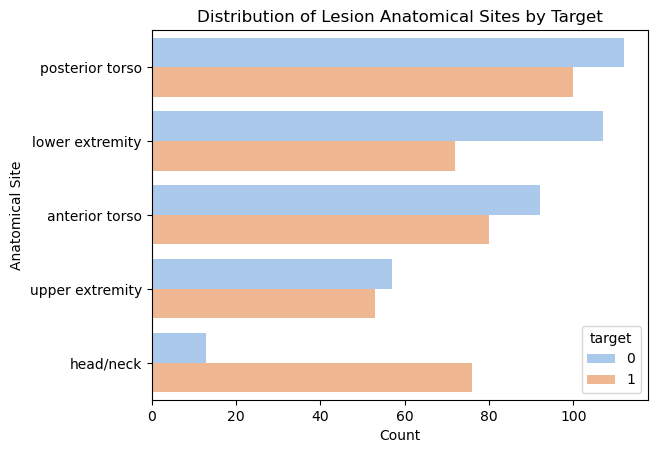

In [35]:
sns.countplot(y='anatom_site_general', data=train_metadata_balanced, palette='pastel', order=train_metadata_balanced['anatom_site_general'].value_counts().index,
              hue='target')  # separate target 0 and target 1

plt.title('Distribution of Lesion Anatomical Sites by Target')
plt.xlabel('Count')
plt.ylabel('Anatomical Site')

plt.show()

###  Lesions are often found on the torso and lower limbs in benign cases, with less frequency on the head/neck. While malign cases has occurred everywhere almost the same way, even in the head/neck.

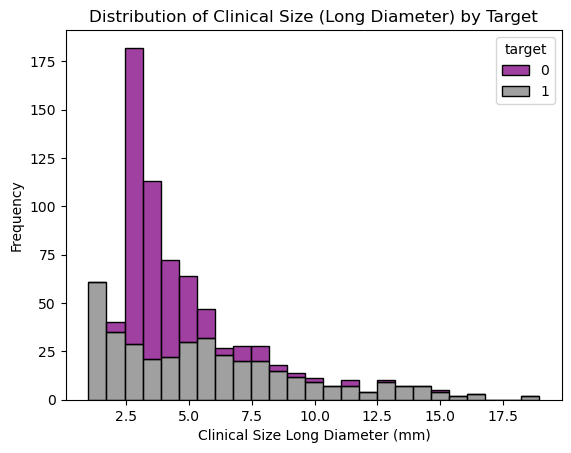

In [36]:
sns.histplot(data=train_metadata_balanced, 
             x='clin_size_long_diam_mm',hue='target', bins=25, color='lightcoral',
             edgecolor='black', multiple="stack", palette=['purple', 'grey'])  # for easier comparison


plt.title('Distribution of Clinical Size (Long Diameter) by Target')
plt.xlabel('Clinical Size Long Diameter (mm)')
plt.ylabel('Frequency')


plt.show()

### Lesions in Benign cases (Target 0) are primarily focused on smaller sizes, whereas Malign cases(Target 1) presents a more diverse size distribution.

# Encoding

In [37]:
# encode sex, 1 for male and 0 for female since they are categorical
train_metadata_balanced['sex'] = train_metadata_balanced['sex'].map({'male': 1, 'female': 0})

# encoding anatom_site_mapping too
anatom_site_mapping = {
    'posterior torso': 1,
    'lower extremity': 2,
    'anterior torso': 3,
    'upper extremity': 4,
    'head/neck': 5
}

# mapping, numeric codes for categorical variables
train_metadata_balanced['anatom_site_general'] = train_metadata_balanced['anatom_site_general'].apply(
    lambda x: anatom_site_mapping.get(x, 0)
)

In [39]:
# encoding tbp_lv_location
tbp_lv_location_mapping = {
    'Torso Front Top Half': 1,
    'Torso Back Top Third': 2,
    'Head & Neck': 3,
    'Torso Back Middle Third': 4,
    'Left Leg - Lower': 5,
    'Right Leg - Lower': 6,
    'Torso Front Bottom Half': 7,
    'Left Arm - Upper': 8,
    'Left Leg - Upper': 9,
    'Right Arm - Upper': 10,
    'Right Leg - Upper': 11,
    'Left Arm - Lower': 12,
    'Right Arm - Lower': 13,
    'Torso Back Bottom Third': 14,
    'Left Leg': 15,
    'Right Leg': 16,
    'Left Arm': 17,
    'Right Arm': 18
}
# apply the mapping, 0 to values not in the mapping
train_metadata_balanced['tbp_lv_location'] = train_metadata_balanced['tbp_lv_location'].apply(
    lambda x: tbp_lv_location_mapping.get(x, 0)
)

In [40]:
# tbp_lv_location_simple
tbp_lv_location_simple_mapping = {
    'Torso Back': 1,
    'Torso Front': 2,
    'Left Leg': 3,
    'Head & Neck': 4,
    'Right Leg': 5,
    'Left Arm': 6,
    'Right Arm': 7
}

train_metadata_balanced['tbp_lv_location_simple'] = train_metadata_balanced['tbp_lv_location_simple'].apply(
    lambda x: tbp_lv_location_simple_mapping.get(x, 0)
)

# model implimentation with CNN (Binary Image Classification), RandomForestClassifier and SVM

### Model implimentation with CNN (Binary Image Classification)

In [60]:
# Features and target
X = train_metadata_balanced.drop(columns=['isic_id', 'target', 'patient_id', 'image_type', 'tbp_tile_type', 'attribution', 'copyright_license', 'iddx_full', 'iddx_1', 'tbp_lv_dnn_lesion_confidence'])
y = train_metadata_balanced['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)# Split the data

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [61]:
# how many features our data has?
n_features = X_scaled.shape[1]
desired_features = 36 * 36  
padding_needed = desired_features - n_features

# pad the data with zeros if there are fewer features
if padding_needed > 0:
    X_padded = np.pad(X_scaled, ((0, 0), (0, padding_needed)), 'constant')
else:
    X_padded = X_scaled  # no padding if we already have the desired features

# Reshape the padded data for CNN input
num_samples = X_padded.shape[0]
X_reshaped = X_padded.reshape(num_samples, 36, 36, 1)  # 36x36 input for CNN


In [62]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

# Define the CNN model with updated input shape (36, 36, 1)
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(36, 36, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Assuming binary classification
])

C:\Users\IamRe\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [63]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [64]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.5359 - loss: 0.6677 - val_accuracy: 0.7705 - val_loss: 0.5363
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.7742 - loss: 0.5374 - val_accuracy: 0.7705 - val_loss: 0.4522
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8211 - loss: 0.4452 - val_accuracy: 0.7951 - val_loss: 0.4256
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7988 - loss: 0.4384 - val_accuracy: 0.7787 - val_loss: 0.4422
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8311 - loss: 0.4055 - val_accuracy: 0.7869 - val_loss: 0.4331
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8167 - loss: 0.4403 - val_accuracy: 0.7951 - val_loss: 0.4129
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8166 - loss: 0.4198 - val_accuracy: 0.8033 - val_loss: 0.4062
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8237 - loss: 0.3991 - val_accuracy: 0.7951 - v

In [65]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8513 - loss: 0.3919
Accuracy: 0.8300653696060181


In [66]:
# Generate predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions (0 or 1)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [67]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        74
           1       0.87      0.78      0.83        79

    accuracy                           0.83       153
   macro avg       0.83      0.83      0.83       153
weighted avg       0.83      0.83      0.83       153



In [68]:
# Save the model
model.save('skin_cancer_cnn_model.keras')

### Model implementation with Random Forest

In [75]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8562091503267973
Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.86      0.85        74
           1       0.87      0.85      0.86        79

    accuracy                           0.86       153
   macro avg       0.86      0.86      0.86       153
weighted avg       0.86      0.86      0.86       153



### Model implementation with SVM

In [78]:
# Initialize the model2
model2 = SVC(kernel='linear', random_state=42)

# Train the model2
model2.fit(X_train, y_train)

# Make predictions
y_pred = model2.predict(X_test)

# Evaluate the model2
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report: SVM \n", classification_report(y_test, y_pred))

Accuracy: 0.7908496732026143
Classification Report: SVM 
               precision    recall  f1-score   support

           0       0.75      0.85      0.80        74
           1       0.84      0.73      0.78        79

    accuracy                           0.79       153
   macro avg       0.80      0.79      0.79       153
weighted avg       0.80      0.79      0.79       153

